This notebook takes heavy inspiration from: https://www.learnpytorch.io/03_pytorch_computer_vision/ (shared under a MIT License), which forms part of a larger course on PyTorch. This content has been modified by Huw Day. If you have the time and want to learn more about deep learning, you should consider doing the full learnpytorch course!

Start off by clicking "Runtime" -> "Change runtime type" -> "T4 GPU"

# Setup PyTorch Device Agnostic Code

We are going to use PyTorch which is a popular (arguably the most popular, certainly in research) deep learning library in Python. Other libraries include Tensorflow, Keras and Jax. We are going to import the needed libraries and make sure that we are using the colab enabled GPU.

In [ ]:
# Import PyTorch
import torch
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device (should be 'cuda' if you changed the runtime):", device)
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

Device (should be 'cuda' if you changed the runtime): cuda
PyTorch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


# Data Setup

We are going to use the [FashionMNIST dataset](https://arxiv.org/abs/1708.07747) which is a commonly used benchmarking dataset of images of different items of clothing. PyTorch lets us import them directly but often in applications you will need to load data in - this can be a faff with larger image datasets, language datasets and especially video datasets. FashionMNIST is by default seperated into a train set and test set.

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [ ]:
# What's the shape of the image?
image, label = train_data[0]
print("Image shape:", image.shape)
input_size = image.shape[0] * image.shape[1] * image.shape[2]
print("Input size:", input_size)

Image shape: torch.Size([1, 28, 28])
Input size: 784


In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
# See classes
class_names = train_data.classes
print(class_names)
print("Output size:", len(class_names))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Output size: 10


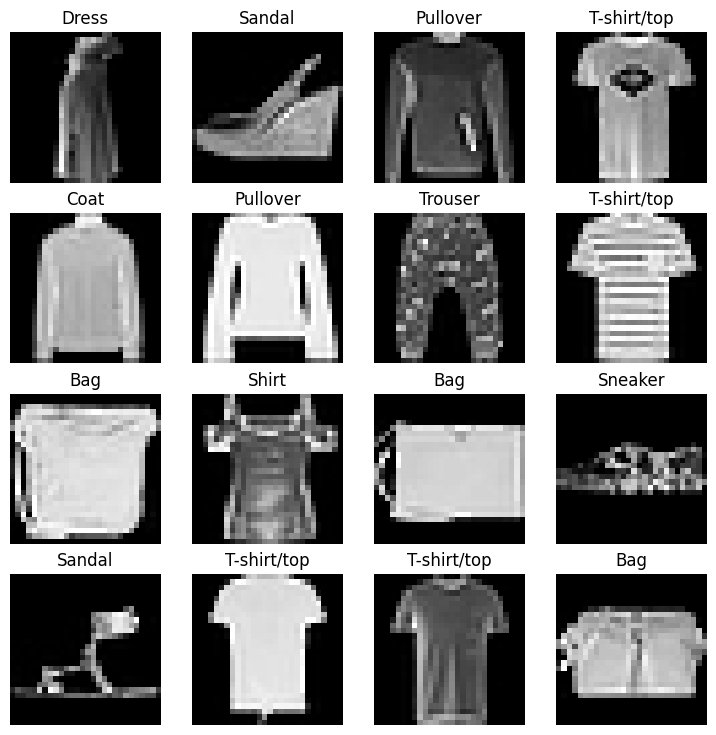

In [ ]:
import matplotlib.pyplot as plt

# Plot some images and their classes
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

What is a DataLoader?

The DataLoader helps load data into a model for training and inference. It turns a large Dataset into a Python iterable of smaller chunks. These smaller chunks are called batches or mini-batches and we can set the batch size as a hyperparameter - it's often set to a power of 2 such as 32 or 64.

With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

Remember that the difference between a **batch** and an **epoch** is that a batch is a single portion of your data than you show the model, an epoch is when your model has seen the entire dataset. Which means that the number of gradient steps you make in an entire epoch is the number of batches it takes to show your model every element of your training data once.

It is common to train for many epochs!


In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fc7f1feb080>, <torch.utils.data.dataloader.DataLoader object at 0x7fc7f1ddd9a0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


Models in PyTorch are represented with classes. If you've not programmed with classes, you've used them before with sklearn models but now you're defining you're own!

In [ ]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  """
  A basic multilayer perceptron (MLP) model built for the FashionMNIST dataset.
  Flattens each image into a single vector
  Passes through a hidden linear layer, into a ReLU activation function
  Passes through another hidden layer, into a ReLU activation function and then outputs
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    """Every class has an "init" method which gets run whenever the class is called.
    In this class we initialise any parameters we might need.
    This can include inheriting parameters from another class (nn.Module) with the line "super().__init__()"
    We also define the layers we want our model to use.
    Args:
        input_shape (int): Number of input features
        hidden_units (int): Number of hidden units between layers
        output_shape (int): Number of output units
    """
    super().__init__()
    self.layer_stack = nn.Sequential(
          nn.Flatten(), # flatten inputs into single vector
          nn.Linear(in_features=input_shape, out_features=hidden_units), # linear layers are defined in a simple way, where you just define the number of input features and output features
          nn.ReLU(),  # use a ReLU activation functions between linear layers
          nn.Linear(in_features=hidden_units, out_features=output_shape),
          nn.ReLU()
          # You could add more layers if you want to (one of the portfolio questions will ask you to do this!)
      )

  def forward(self, x: torch.Tensor):
    """All PyTorch models need a "forward" method. This takes in an input and feeds it forward through the model"""
    return self.layer_stack(x)

Now we define an instance of the model with the arguments we need for our neural network task (i.e. input_shape and out_shape corresponding to the size of our images and the number of classes respectively)

In [ ]:
model_1 = FashionMNISTModelV1(input_shape=input_size, # number of input features
    hidden_units=32, # The size of our hidden layers is arbitrary and easily changed - you could even have different hidden layers with different sizes!
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

We'll write some functions here to help us with running, training, testing and evaluating our models. In practise you might have these in a seperate custom module (e.g. DL_utils.py) which you could import in!

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Defining a loss function (https://docs.pytorch.org/docs/stable/nn.html#loss-functions) and our optimizer for training our first model (https://docs.pytorch.org/docs/stable/optim.html#how-to-use-an-optimizer). We are going to use Cross Entropy Loss and a basic version of stochastic gradient descent. You could play around with different optimizers and learning rates.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

Whilst you could write "train" and "test" functions, it's often better to have a single train_step which you can loop over for a certain number of epochs so that you can track how your model performs over each epoch.

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

Now we can run the training loop for a set number of epochs! Progress will be tracked below. Running for epochs = 10 and batch size = 32 this took about 2 minutes to train (this is an extremely short training cycle but just for demo purposes!)

In [ ]:
from tqdm import tqdm

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

test_loss_list = []
test_acc_list = []
train_loss_list = []
train_acc_list = []

# Set the number of epochs
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
    train_loss_list.append(train_loss.item())
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.81252 | Train accuracy: 69.96%


 10%|█         | 1/10 [00:11<01:46, 11.80s/it]

Test loss: 0.67317 | Test accuracy: 74.72%

Epoch: 1
---------
Train loss: 0.64500 | Train accuracy: 75.33%


 20%|██        | 2/10 [00:23<01:35, 12.00s/it]

Test loss: 0.64862 | Test accuracy: 75.47%

Epoch: 2
---------
Train loss: 0.52517 | Train accuracy: 80.15%


 30%|███       | 3/10 [00:50<02:11, 18.81s/it]

Test loss: 0.42432 | Test accuracy: 85.15%

Epoch: 3
---------
Train loss: 0.37179 | Train accuracy: 86.60%


 40%|████      | 4/10 [01:08<01:50, 18.45s/it]

Test loss: 0.42334 | Test accuracy: 85.18%

Epoch: 4
---------
Train loss: 0.35394 | Train accuracy: 87.23%


 50%|█████     | 5/10 [01:18<01:16, 15.21s/it]

Test loss: 0.44059 | Test accuracy: 85.00%

Epoch: 5
---------
Train loss: 0.34147 | Train accuracy: 87.48%


 60%|██████    | 6/10 [01:28<00:53, 13.38s/it]

Test loss: 0.38950 | Test accuracy: 85.79%

Epoch: 6
---------
Train loss: 0.33116 | Train accuracy: 87.91%


 70%|███████   | 7/10 [01:37<00:36, 12.22s/it]

Test loss: 0.37552 | Test accuracy: 86.63%

Epoch: 7
---------
Train loss: 0.32372 | Train accuracy: 88.13%


 80%|████████  | 8/10 [01:48<00:23, 11.59s/it]

Test loss: 0.39187 | Test accuracy: 86.32%

Epoch: 8
---------
Train loss: 0.31569 | Train accuracy: 88.49%


 90%|█████████ | 9/10 [02:00<00:11, 11.73s/it]

Test loss: 0.37677 | Test accuracy: 86.58%

Epoch: 9
---------
Train loss: 0.30885 | Train accuracy: 88.60%


100%|██████████| 10/10 [02:10<00:00, 13.00s/it]

Test loss: 0.36602 | Test accuracy: 86.84%

Train time on cuda: 130.020 seconds


It's always good to plot your test and train loss curves! They can tell you how much you might want to tune your learning rate, if you need to train for more epochs, if your model might be overfitting to the training data and performing worse on the test data and perhaps if you need to make your model more complicated.

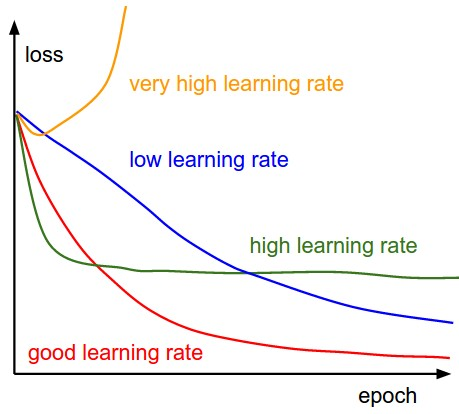

- Very high learning rate (yellow curve) typically produces diverging loss that increases over time, indicating unstable optimisation where parameter updates overshoot minima and potentially cause numerical instability.
- High learning rates (green curve) show rapid initial progress followed by oscillation or plateauing, suggesting the model approaches optimal regions quickly but lacks the precision to settle properly, bouncing around like a ball with too much energy.
- Good learning rates (red curve) display steady, consistent decreases that eventually flatten at low values, representing an ideal balance between speed and stability that allows the model to converge efficiently.
- Low learning rates (blue curve) produce very slow, almost linear decreases in loss, indicating cautious parameter updates that never overshoot but require significantly more computational resources and training time.

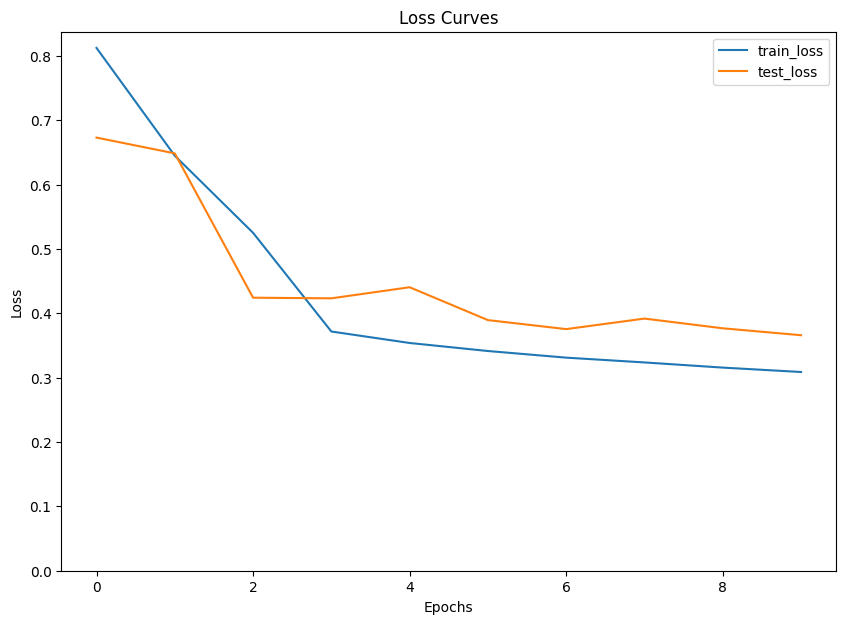

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_loss_list, label="train_loss")
plt.plot(test_loss_list, label="test_loss")
plt.ylim(0)
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

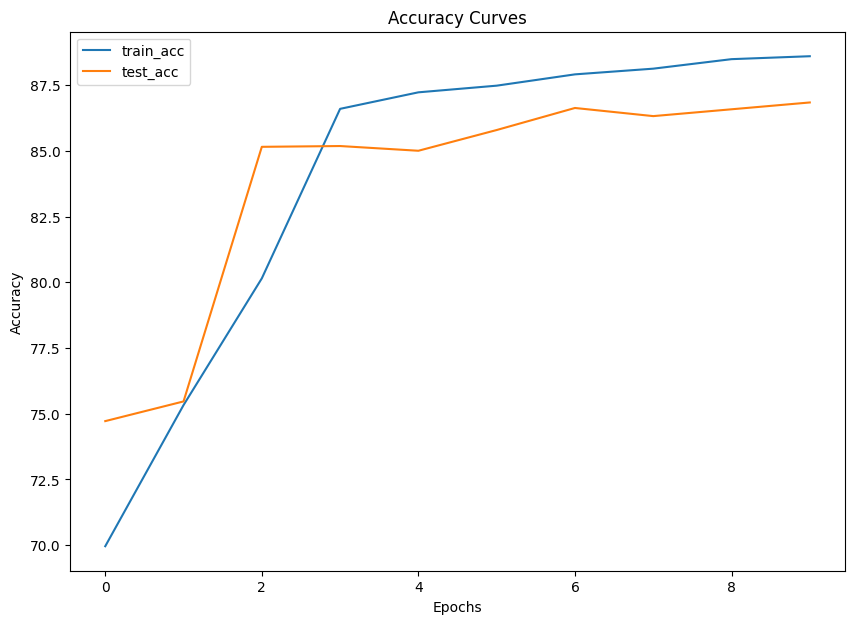

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_acc_list, label="train_acc")
plt.plot(test_acc_list, label="test_acc")
plt.title("Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

We are going to evaluate our model now! This will make it easier to compare multiple models against one another.

In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.3660152554512024,
 'model_acc': 86.84105431309904}

Next we are going to make a convolutional neural network (CNN) specifically adapated for image recognition. Note we don't "flatten" the image straight away like we did before. Go and read this explainer on CNNs for more details: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    It has two convolution blocks (block 1 and block 2) and a classification block at the end.

    Args:
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers.
        output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

This one takes about two minutes to train as well! (For 10 epochs, batch size of 32).

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), # note that we need model_2 parameters here!
                            lr=0.1)

test_loss_list = []
test_acc_list = []
train_loss_list = []
train_acc_list = []

# Measure time; this model took about 10 minutes to train with epochs = 10
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_acc = test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_list.append(train_loss.item())
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.57970 | Train accuracy: 78.98%


 10%|█         | 1/10 [00:11<01:47, 11.99s/it]

Test loss: 0.40632 | Test accuracy: 84.51%

Epoch: 1
---------
Train loss: 0.35566 | Train accuracy: 87.14%


 20%|██        | 2/10 [00:23<01:35, 11.92s/it]

Test loss: 0.36477 | Test accuracy: 86.34%

Epoch: 2
---------
Train loss: 0.31626 | Train accuracy: 88.59%


 30%|███       | 3/10 [00:38<01:32, 13.18s/it]

Test loss: 0.32043 | Test accuracy: 88.10%

Epoch: 3
---------
Train loss: 0.29367 | Train accuracy: 89.28%


 40%|████      | 4/10 [00:50<01:16, 12.70s/it]

Test loss: 0.30956 | Test accuracy: 88.71%

Epoch: 4
---------
Train loss: 0.27951 | Train accuracy: 89.80%


 50%|█████     | 5/10 [01:02<01:02, 12.43s/it]

Test loss: 0.30139 | Test accuracy: 89.50%

Epoch: 5
---------
Train loss: 0.27003 | Train accuracy: 90.28%


 60%|██████    | 6/10 [01:14<00:48, 12.24s/it]

Test loss: 0.28914 | Test accuracy: 89.47%

Epoch: 6
---------
Train loss: 0.26095 | Train accuracy: 90.62%


 70%|███████   | 7/10 [01:26<00:36, 12.13s/it]

Test loss: 0.30403 | Test accuracy: 88.83%

Epoch: 7
---------
Train loss: 0.25343 | Train accuracy: 90.87%


 80%|████████  | 8/10 [01:38<00:24, 12.07s/it]

Test loss: 0.28321 | Test accuracy: 89.74%

Epoch: 8
---------
Train loss: 0.24879 | Train accuracy: 91.00%


 90%|█████████ | 9/10 [01:49<00:11, 12.00s/it]

Test loss: 0.28063 | Test accuracy: 89.79%

Epoch: 9
---------
Train loss: 0.24459 | Train accuracy: 91.00%


100%|██████████| 10/10 [02:01<00:00, 12.19s/it]

Test loss: 0.27475 | Test accuracy: 89.90%

Train time on cuda: 121.881 seconds


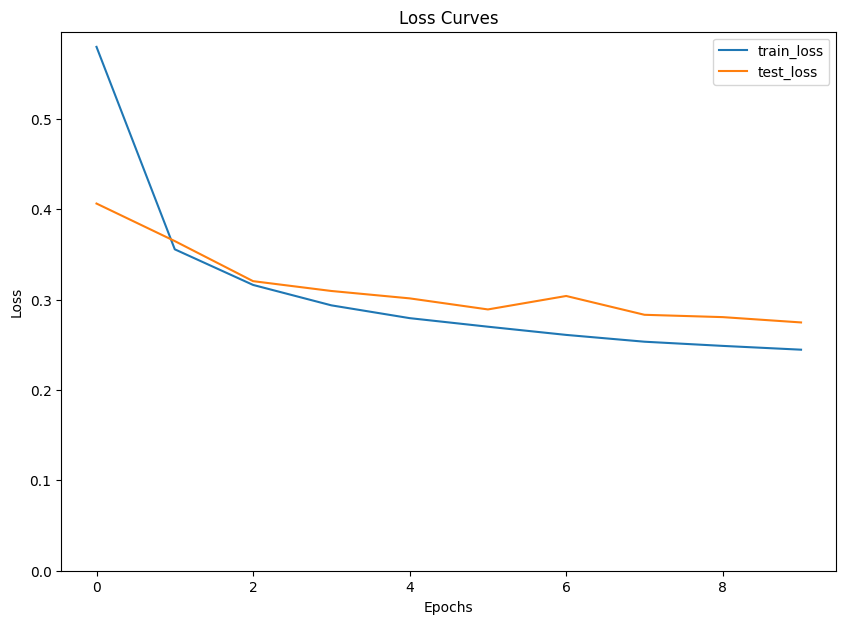

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss_list, label="train_loss")
plt.plot(test_loss_list, label="test_loss")
plt.ylim(0)
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

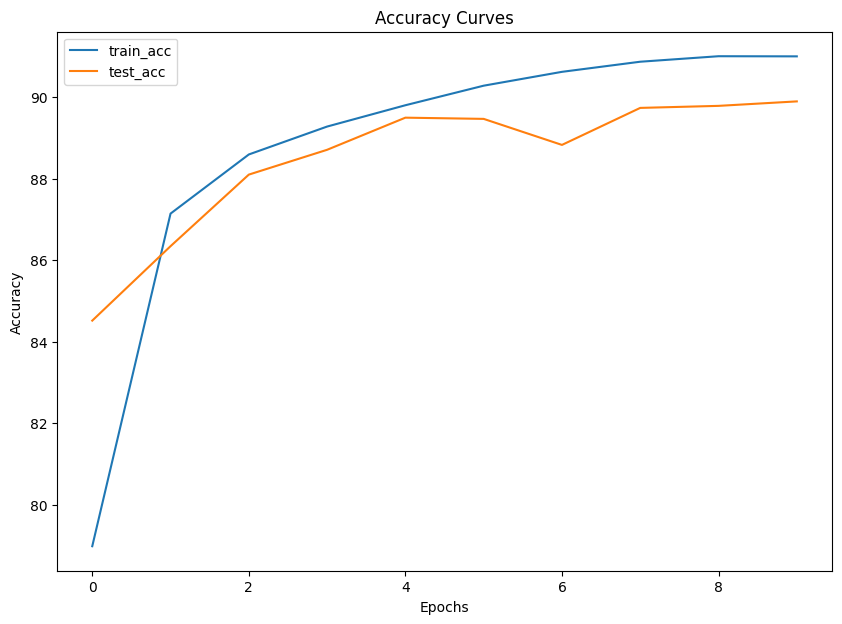

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_acc_list, label="train_acc")
plt.plot(test_acc_list, label="test_acc")
plt.title("Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2747487425804138,
 'model_acc': 89.89616613418531}

# Visualising Results

Loss over epochs is good for diagnosing model performance for making tweaks, but as with all predictive tasks, it's vital (both to other people using your model but also for yourself) to visualise your results. Below is some code to do that!

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random
random.seed(42) # Set random seed so that your colab notebook is the same as everyone else's

test_samples = []
test_labels = []

# Get some random test data out
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

In [ ]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 6, 4, 7, 1]))

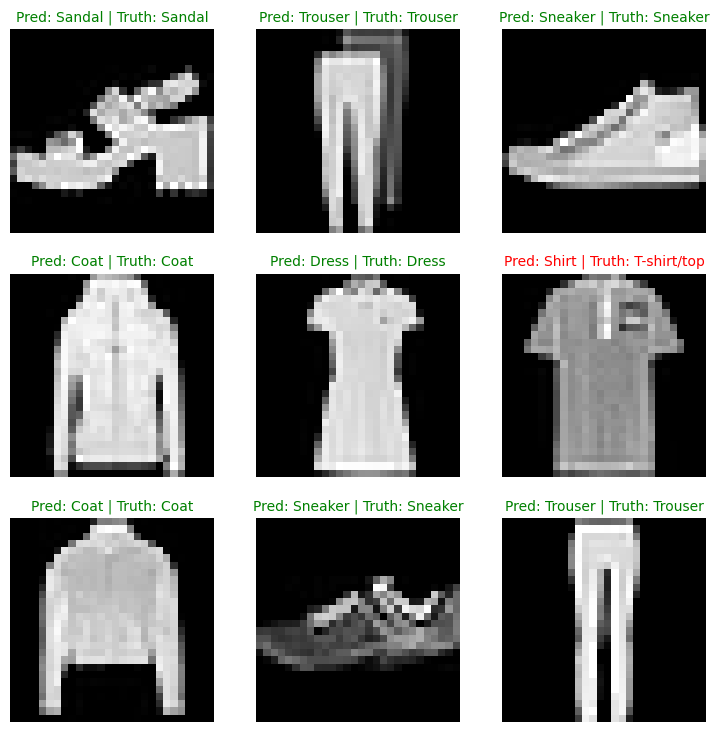

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

mlxtend version: 0.23.4
0.23.4


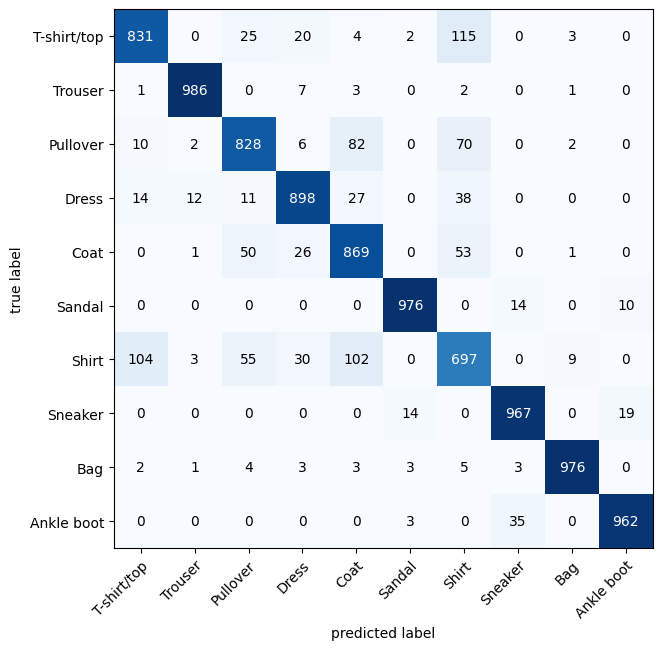

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Saving and loading models

In practise, you often won't train a model from scratch, you'll use someone else's! But it's still important to know how to define and train a model from scratch. PyTorch let's you save and load in models.

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "Model2CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2747487425804138,
 'model_acc': 89.89616613418531}

# Portfolio Questions

## 1. Investigating the Universal Approximation Theorem for MLPs

Investigate the limits of the Universal Approximation Theorem for MLPs, which says that an MLP with a single hidden layer of arbitrary width can approximate any continuous function

Take model_1, the first MLP from lab code and modify its architecture. First train it with 1 hidden layer with 64 neurons, compare this with 2 hidden layers with 32 each etc. for a variety of different configuration of hidden layers (make sure you have activation functions between, you might want to use a loop inside your class to make this easier to define).

For a fixed number of epochs, record the training speed, model performance, minimum test loss etc. Produce some plots and explain your observations. You might want to watch this video for some inspiration: https://youtu.be/qx7hirqgfuU?si=45VlYxsbazvJYv3b

## 2. Improving CNN Performance

Augment the code for model_2 (the CNN) to try and improve the performance by including modifying your dataloader and training algorithms. For each, play around with appropriate parameters to see what works best for performance. For each feature you use, write a short piece explaining what each one does and document how it affects performance:

- Adjusting learning rate
- Use a different optimizer like Adam or AdamW https://docs.pytorch.org/docs/main/optim.html
- Adjusting batch size
- Implement random transforms on your dataloaders (think about which transforms are appropriate for train/test loader) https://docs.pytorch.org/vision/main/transforms.html
- Dropout https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

## 3. Transformers need glasses!

Read the paper "Transformers need glasses! Information over-squashing in language tasks" (https://arxiv.org/abs/2406.04267) You could also listen to the podcast with the authors as well (https://www.youtube.com/watch?v=FAspMnu4Rt0).

You're going to try and replicate some of the experiments and give an intuitive explanation of the results. To replicate the results, you should make a new google collab notebook and use some of the free transformer models. Within the collab notebook, remember to change runtime to GPU. You should use models from the transformers library for experiments (see example code below!)
These are free but significantly worse performing than the models used in the paper so you should expect your results to reflect that!

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "gpt2" # For example, you could use other

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# === Function to run a prompt ===
def run_prompt(prompt, max_new_tokens=10, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature = temperature,
            pad_token_id=tokenizer.eos_token_id
        )
    # Decode to string
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Prompt out is: \n", result)
    return result

# === Example usage ===
prompt = "The capital of Germany is Berlin. The capital of England is London. The capital of Wales is Cardiff. The capital of France is:"
run_prompt(prompt, max_new_tokens=3)

print("\n We did tell you the free models are worse!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Prompt out is: 
 The capital of Germany is Berlin. The capital of England is London. The capital of Wales is Cardiff. The capital of France is:

*

 We did tell you the free models are worse!
